In [1]:
# Import required libraries
from surprise import Reader, Dataset, accuracy
from surprise.model_selection import train_test_split, cross_validate, PredefinedKFold
from surprise import SVD, SVDpp, SlopeOne, NMF, NormalPredictor
from surprise import KNNBaseline, KNNBasic, KNNWithMeans, KNNWithZScore
from surprise import BaselineOnly, CoClustering
# import recmetrics as recmetrics ---> https://morioh.com/p/7208a4c1946d

import sklearn.metrics as metrics
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix
from sklearn.cluster import KMeans
import seaborn as sns


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from plotly.offline import init_notebook_mode, plot, iplot
import plotly.graph_objs as go

O conjunto de treino passa a consistir nas primeiras ~400 votações (existem 450 no total, mais ou menos), e um máximo de 10% das seguintes ~50. O teste serão os 90% de cada uma destas últimas votações

In [2]:
def get_top_users_by_error(predictions, dataset ,n=10, ascending=True):
    user_errors = {}

    # Calculate the error for each user
    for pred in predictions:
        uid = pred.uid
        error = abs(pred.est - pred.r_ui)

        if uid in user_errors:
            user_errors[uid] += error
        else:
            user_errors[uid] = error
    
    # Sort the users based on the total error in ascending or descending order
    sorted_users = sorted(user_errors.items(), key=lambda x: x[1], reverse=not ascending)

    # top users
    top_users = [(dataset.loc[dataset['deputado_enc'] == user[0], 'deputado_nome'].values[0],
                  dataset.loc[dataset['deputado_enc'] == user[0], 'deputado_siglaPartido'].values[0],
                  user[1]) for user in sorted_users[:n]]
    
    return top_users


def clusters_users(predictions, num_clusters=10):
    user_ratings = {}  # Dictionary to store user ratings by cluster

    # Collect user ratings for each cluster
    for p in predictions:
        if p.uid not in user_ratings:
            user_ratings[p.uid] = {'True Rating': [], 'Predicted Rating': []}
        user_ratings[p.uid]['True Rating'].append(p.r_ui)
        user_ratings[p.uid]['Predicted Rating'].append(p.est)

    # Prepare the data for clustering
    data = []
    for uid, ratings in user_ratings.items():
        data.append([sum(ratings['True Rating']) / len(ratings['True Rating']), sum(ratings['Predicted Rating']) / len(ratings['Predicted Rating'])])

    # Apply K-means clustering
    kmeans = KMeans(n_clusters=num_clusters)
    cluster_labels = kmeans.fit_predict(data)

    # Add cluster labels to the user ratings dictionary
    for i, uid in enumerate(user_ratings):
        user_ratings[uid]['Cluster'] = cluster_labels[i]

    # Prepare the data for visualization
    data = []
    for uid, ratings in user_ratings.items():
        for true_rating, predicted_rating in zip(ratings['True Rating'], ratings['Predicted Rating']):
            data.append({'User ID': uid, 'Cluster': ratings['Cluster'], 'True Rating': true_rating, 'Predicted Rating': predicted_rating})

    # Create a DataFrame
    df = pd.DataFrame(data)

    # Group users by cluster and calculate average true rating and predicted rating
    grouped_df = df.groupby(['Cluster', 'User ID']).agg({'True Rating': 'mean', 'Predicted Rating': 'mean'})
    grouped_df = grouped_df.reset_index()

    return grouped_df

 
def evaluate_algorithms_binary(trainset, testset, algorithms, dt):
  
    results = {}    
    for algorithm in algorithms:
        # train 
        algorithm.fit(trainset)
        
        # test
        predictions = algorithm.test(testset)

        # predicted ratings to 0 or 1 
        binary_predictions = [1 if p.est >= 0.5 else 0 for p in predictions]
        
        # binary_true_ratings is not needed -> does not change anything
        binary_true_ratings = [1 if p.r_ui >= 0.5 else 0 for p in predictions]

        # Metrics
        acc = accuracy_score(binary_true_ratings, binary_predictions)
        precision, recall, f1_score, _ = precision_recall_fscore_support(binary_true_ratings, binary_predictions, average='binary')
        rmse = accuracy.rmse(predictions)
        mae = accuracy.mae(predictions)
        
        # Store results in dictionary
        results[algorithm.__class__.__name__] = {
            'accuracy': acc,
            'precision': precision,
            'recall': recall,
            'f1_score': f1_score,
            'test_rmse': rmse,
            'test_mae': mae,
        }

    # Convert dictionary to DataFrame and sort by F1 score
    results = pd.DataFrame.from_dict(results, orient='index')
    top10_high = get_top_users_by_error(predictions,dt, n=10, ascending=False)
    top10_low = get_top_users_by_error(predictions,dt, n=10, ascending=True)
    return results, top10_high,top10_low

In [3]:
def realistic_train_test(algorithms, dt, n=0.1):
    reader = Reader(rating_scale=(0, 1))
    dt = dt.sort_values(by='idVotacao')
    data = Dataset.load_from_df(dt[['deputado_enc', 'idVotacao', 'vote_enc']], reader)
    
    # first ~350
    train_indices = dt['idVotacao'].unique()[:350]
    # last ~50 votes
    test_indices = dt['idVotacao'].unique()[-50:]

    train_data = dt[dt['idVotacao'].isin(train_indices)]
    test_data = pd.DataFrame()

    for test_index in test_indices:
        test_votes = dt[dt['idVotacao'] == test_index]

        #10% of the votes for the train set
        size = int(len(test_votes) * n)
        
        #randomly select n rows from test_votes to into the train data
        train_votes = test_votes.sample(n=size, random_state=42)

        # add to train set
        train_data = pd.concat([train_data, train_votes])

        # remaining votes for the test set
        test_votes = test_votes[~test_votes.index.isin(train_votes.index)]
        test_data = pd.concat([test_data, test_votes])
        
    # remaining votes to train - it removes what was already used for test
    train_data = dt[~dt[['deputado_enc', 'idVotacao']].isin(test_data[['deputado_enc', 'idVotacao']]).all(axis=1)]

    trainset = Dataset.load_from_df(train_data[['deputado_enc', 'idVotacao', 'vote_enc']], reader).build_full_trainset()
    testset = Dataset.load_from_df(test_data[['deputado_enc', 'idVotacao', 'vote_enc']], reader).build_full_trainset().build_testset()

    ## use function to evaluate results
    results, top10_high, top10_low = evaluate_algorithms_binary(trainset,testset, algorithms, dt)
    return results, top10_high, top10_low

In [4]:
def binary_knn_baseline(data, k=40, min_k=1, sim_options=None):
    """
    Builds and evaluates a KNNBaseline recommendation system
    """
    reader = Reader(rating_scale=(0, 1))
    data = Dataset.load_from_df(dfP[['deputado_enc', 'idVotacao', 'vote_enc']], reader)
    trainset, testset = train_test_split(data, test_size=0.90)

    # Build the KNNBaseline recommendation system with the specified parameters
    if sim_options is None:
        sim_options = {'name': 'pearson_baseline', 'user_based': False}
        
    algo = KNNBaseline(k=k, min_k=min_k, sim_options=sim_options)
    r = evaluate_algorithms_binary(trainset, testset, algo)
    return r

In [5]:
# Load the data into a pandas dataframe
dfP = pd.read_csv('..\data\preprocessed\dataVoting.csv')
dfP

,Unnamed: 0,idVotacao,siglaOrgao,idEvento,aprovacao,uriVotacao,voto,deputado_id,deputado_nome,deputado_siglaPartido,...,idLegislaturaFinal,siglaSexo,municipioNascimento,idade,new,score_accordingly,deputado_enc,orientacao_enc,gender_enc,vote_enc
0,0,2312874-9,PLEN,64653,1.0,https://dadosabertos.camara.leg.br/api/v2/vota...,Sim,204554,Abílio Santana,PL,...,56,M,Salvador,58.0,0,72.56,2,1,1,4
1,1,46249-294,PLEN,64653,0.0,https://dadosabertos.camara.leg.br/api/v2/vota...,Não,204554,Abílio Santana,PL,...,56,M,Salvador,58.0,1,72.56,2,1,1,2
2,2,46249-297,PLEN,64653,1.0,https://dadosabertos.camara.leg.br/api/v2/vota...,Sim,204554,Abílio Santana,PL,...,56,M,Salvador,58.0,1,72.56,2,3,1,4
3,3,46249-312,PLEN,64653,2.0,https://dadosabertos.camara.leg.br/api/v2/vota...,Sim,204554,Abílio Santana,PL,...,56,M,Salvador,58.0,0,72.56,2,1,1,4
4,4,46249-316,PLEN,64653,0.0,https://dadosabertos.camara.leg.br/api/v2/vota...,Não,204554,Abílio Santana,PL,...,56,M,Salvador,58.0,1,72.56,2,1,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112151,112151,2323617-49,PLEN,66394,2.0,https://dadosabertos.camara.leg.br/api/v2/vota...,Sim,122466,Ronaldo Martins,REPUBLICANOS,...,56,M,São Paulo,45.0,0,68.00,317,0,1,4
112152,112152,2323617-56,PLEN,66394,0.0,https://dadosabertos.camara.leg.br/api/v2/vota...,Não,122466,Ronaldo Martins,REPUBLICANOS,...,56,M,São Paulo,45.0,1,68.00,317,1,1,2
112153,112153,2314962-33,PLEN,66455,1.0,https://dadosabertos.camara.leg.br/api/v2/vota...,Sim,122466,Ronaldo Martins,REPUBLICANOS,...,56,M,São Paulo,45.0,1,68.00,317,3,1,4
112154,112154,2326278-38,PLEN,66439,0.0,https://dadosabertos.camara.leg.br/api/v2/vota...,Não,205535,Patricia Ferraz,PODE,...,56,F,Belo Horizonte,43.0,1,40.76,277,1,0,2


In [6]:
df_bool = dfP.loc[(dfP["vote_enc"] == 2) | (dfP["vote_enc"] == 4)] 
## replace values for 2 and 4 to 0 and 1
df_bool["vote_enc"].replace({2: 0, 4: 1}, inplace=True)
df_bool

C:\Users\ritac\anaconda3\lib\site-packages\pandas\core\generic.py:6619: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,Unnamed: 0,idVotacao,siglaOrgao,idEvento,aprovacao,uriVotacao,voto,deputado_id,deputado_nome,deputado_siglaPartido,...,idLegislaturaFinal,siglaSexo,municipioNascimento,idade,new,score_accordingly,deputado_enc,orientacao_enc,gender_enc,vote_enc
0,0,2312874-9,PLEN,64653,1.0,https://dadosabertos.camara.leg.br/api/v2/vota...,Sim,204554,Abílio Santana,PL,...,56,M,Salvador,58.0,0,72.56,2,1,1,1
1,1,46249-294,PLEN,64653,0.0,https://dadosabertos.camara.leg.br/api/v2/vota...,Não,204554,Abílio Santana,PL,...,56,M,Salvador,58.0,1,72.56,2,1,1,0
2,2,46249-297,PLEN,64653,1.0,https://dadosabertos.camara.leg.br/api/v2/vota...,Sim,204554,Abílio Santana,PL,...,56,M,Salvador,58.0,1,72.56,2,3,1,1
3,3,46249-312,PLEN,64653,2.0,https://dadosabertos.camara.leg.br/api/v2/vota...,Sim,204554,Abílio Santana,PL,...,56,M,Salvador,58.0,0,72.56,2,1,1,1
4,4,46249-316,PLEN,64653,0.0,https://dadosabertos.camara.leg.br/api/v2/vota...,Não,204554,Abílio Santana,PL,...,56,M,Salvador,58.0,1,72.56,2,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112151,112151,2323617-49,PLEN,66394,2.0,https://dadosabertos.camara.leg.br/api/v2/vota...,Sim,122466,Ronaldo Martins,REPUBLICANOS,...,56,M,São Paulo,45.0,0,68.00,317,0,1,1
112152,112152,2323617-56,PLEN,66394,0.0,https://dadosabertos.camara.leg.br/api/v2/vota...,Não,122466,Ronaldo Martins,REPUBLICANOS,...,56,M,São Paulo,45.0,1,68.00,317,1,1,0
112153,112153,2314962-33,PLEN,66455,1.0,https://dadosabertos.camara.leg.br/api/v2/vota...,Sim,122466,Ronaldo Martins,REPUBLICANOS,...,56,M,São Paulo,45.0,1,68.00,317,3,1,1
112154,112154,2326278-38,PLEN,66439,0.0,https://dadosabertos.camara.leg.br/api/v2/vota...,Não,205535,Patricia Ferraz,PODE,...,56,F,Belo Horizonte,43.0,1,40.76,277,1,0,0


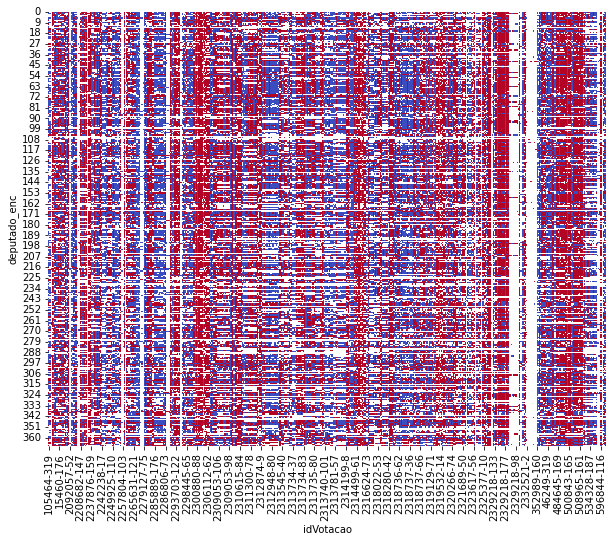

In [7]:
# Create a pivot table with NC as rows, A as columns, and rating as values
pivot_table = df_bool.pivot_table(index='deputado_enc', columns='idVotacao', values='vote_enc')
    
# Create a heatmap
plt.figure(figsize=(10,8))
sns.heatmap(pivot_table, cmap='coolwarm', cbar=False)
plt.show()

In [8]:
df_bool['idVotacao'].value_counts()

2329218-153    334
508965-164     332
2329218-162    331
2329218-192    330
2329218-165    329
              ... 
2334095-31       3
2334096-29       2
2334095-19       2
2334096-11       1
2334095-11       1
Name: idVotacao, Length: 473, dtype: int64

In [10]:
# count the number of times each voting id appears in the dataset
counts = df_bool.groupby("idVotacao").size()
mask = counts > 200
voting_ids = counts[mask].index.tolist()

mask = df_bool["idVotacao"].isin(voting_ids)

df_filtered = df_bool[mask]
df_filtered

,Unnamed: 0,idVotacao,siglaOrgao,idEvento,aprovacao,uriVotacao,voto,deputado_id,deputado_nome,deputado_siglaPartido,...,idLegislaturaFinal,siglaSexo,municipioNascimento,idade,new,score_accordingly,deputado_enc,orientacao_enc,gender_enc,vote_enc
0,0,2312874-9,PLEN,64653,1.0,https://dadosabertos.camara.leg.br/api/v2/vota...,Sim,204554,Abílio Santana,PL,...,56,M,Salvador,58.0,0,72.56,2,1,1,1
1,1,46249-294,PLEN,64653,0.0,https://dadosabertos.camara.leg.br/api/v2/vota...,Não,204554,Abílio Santana,PL,...,56,M,Salvador,58.0,1,72.56,2,1,1,0
2,2,46249-297,PLEN,64653,1.0,https://dadosabertos.camara.leg.br/api/v2/vota...,Sim,204554,Abílio Santana,PL,...,56,M,Salvador,58.0,1,72.56,2,3,1,1
3,3,46249-312,PLEN,64653,2.0,https://dadosabertos.camara.leg.br/api/v2/vota...,Sim,204554,Abílio Santana,PL,...,56,M,Salvador,58.0,0,72.56,2,1,1,1
4,4,46249-316,PLEN,64653,0.0,https://dadosabertos.camara.leg.br/api/v2/vota...,Não,204554,Abílio Santana,PL,...,56,M,Salvador,58.0,1,72.56,2,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112150,112150,2324900-55,PLEN,66394,2.0,https://dadosabertos.camara.leg.br/api/v2/vota...,Sim,122466,Ronaldo Martins,REPUBLICANOS,...,56,M,São Paulo,45.0,1,68.00,317,3,1,1
112152,112152,2323617-56,PLEN,66394,0.0,https://dadosabertos.camara.leg.br/api/v2/vota...,Não,122466,Ronaldo Martins,REPUBLICANOS,...,56,M,São Paulo,45.0,1,68.00,317,1,1,0
112153,112153,2314962-33,PLEN,66455,1.0,https://dadosabertos.camara.leg.br/api/v2/vota...,Sim,122466,Ronaldo Martins,REPUBLICANOS,...,56,M,São Paulo,45.0,1,68.00,317,3,1,1
112154,112154,2326278-38,PLEN,66439,0.0,https://dadosabertos.camara.leg.br/api/v2/vota...,Não,205535,Patricia Ferraz,PODE,...,56,F,Belo Horizonte,43.0,1,40.76,277,1,0,0


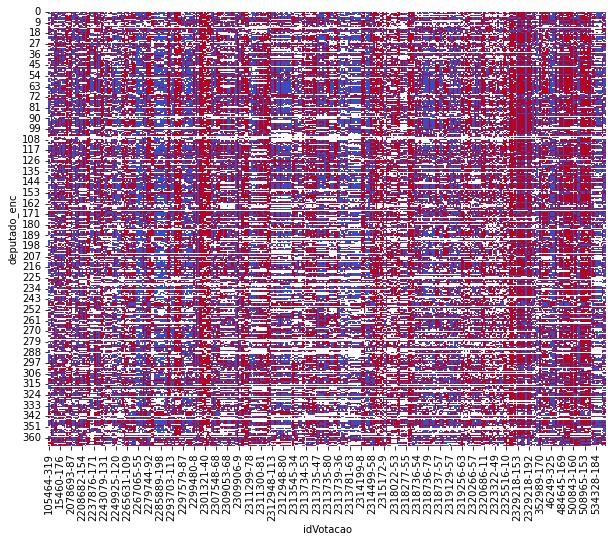

In [11]:
# Create a pivot table with NC as rows, A as columns, and rating as values
pivot_table = df_filtered.pivot_table(index='deputado_enc', columns='idVotacao', values='vote_enc')

# Create a heatmap
plt.figure(figsize=(10,8))
sns.heatmap(pivot_table, cmap='coolwarm', cbar=False)
plt.show()

In [12]:
df_filtered['idVotacao'].value_counts()

2329218-153    334
508965-164     332
2329218-162    331
2329218-192    330
2329218-165    329
              ... 
2313781-70     205
2283448-53     205
2324900-47     203
2243079-167    202
2316624-73     201
Name: idVotacao, Length: 400, dtype: int64

In [13]:
df_filtered.groupby(['deputado_enc', 'idVotacao']).tail(1)

,Unnamed: 0,idVotacao,siglaOrgao,idEvento,aprovacao,uriVotacao,voto,deputado_id,deputado_nome,deputado_siglaPartido,...,idLegislaturaFinal,siglaSexo,municipioNascimento,idade,new,score_accordingly,deputado_enc,orientacao_enc,gender_enc,vote_enc
0,0,2312874-9,PLEN,64653,1.0,https://dadosabertos.camara.leg.br/api/v2/vota...,Sim,204554,Abílio Santana,PL,...,56,M,Salvador,58.0,0,72.56,2,1,1,1
1,1,46249-294,PLEN,64653,0.0,https://dadosabertos.camara.leg.br/api/v2/vota...,Não,204554,Abílio Santana,PL,...,56,M,Salvador,58.0,1,72.56,2,1,1,0
2,2,46249-297,PLEN,64653,1.0,https://dadosabertos.camara.leg.br/api/v2/vota...,Sim,204554,Abílio Santana,PL,...,56,M,Salvador,58.0,1,72.56,2,3,1,1
3,3,46249-312,PLEN,64653,2.0,https://dadosabertos.camara.leg.br/api/v2/vota...,Sim,204554,Abílio Santana,PL,...,56,M,Salvador,58.0,0,72.56,2,1,1,1
4,4,46249-316,PLEN,64653,0.0,https://dadosabertos.camara.leg.br/api/v2/vota...,Não,204554,Abílio Santana,PL,...,56,M,Salvador,58.0,1,72.56,2,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112150,112150,2324900-55,PLEN,66394,2.0,https://dadosabertos.camara.leg.br/api/v2/vota...,Sim,122466,Ronaldo Martins,REPUBLICANOS,...,56,M,São Paulo,45.0,1,68.00,317,3,1,1
112152,112152,2323617-56,PLEN,66394,0.0,https://dadosabertos.camara.leg.br/api/v2/vota...,Não,122466,Ronaldo Martins,REPUBLICANOS,...,56,M,São Paulo,45.0,1,68.00,317,1,1,0
112153,112153,2314962-33,PLEN,66455,1.0,https://dadosabertos.camara.leg.br/api/v2/vota...,Sim,122466,Ronaldo Martins,REPUBLICANOS,...,56,M,São Paulo,45.0,1,68.00,317,3,1,1
112154,112154,2326278-38,PLEN,66439,0.0,https://dadosabertos.camara.leg.br/api/v2/vota...,Não,205535,Patricia Ferraz,PODE,...,56,F,Belo Horizonte,43.0,1,40.76,277,1,0,0


In [15]:
##OLD FUNCTION ~ WITOUHOUT JOINED 10% OF TEST
algorithms = [SVD(), SlopeOne(), NMF(), NormalPredictor(), KNNBaseline(), KNNWithMeans(), BaselineOnly(), CoClustering()]
results1 = realistic_train_test(algorithms, df_filtered)
results1

RMSE: 0.3132
MAE:  0.2429
RMSE: 0.3913
MAE:  0.3015
RMSE: 0.2436
MAE:  0.1717
RMSE: 0.6096
MAE:  0.4927
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.3630
MAE:  0.2650
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.3645
MAE:  0.2668
Estimating biases using als...
RMSE: 0.3988
MAE:  0.3485
RMSE: 0.2353
MAE:  0.1195


(                 accuracy  precision    recall  f1_score  test_rmse  test_mae
 SVD              0.884531   0.882178  0.924408  0.902800   0.313205  0.242901
 SlopeOne         0.814951   0.813652  0.883300  0.847047   0.391286  0.301454
 NMF              0.942736   0.952355  0.948749  0.950549   0.243621  0.171723
 NormalPredictor  0.507060   0.578383  0.554293  0.566082   0.609648  0.492687
 KNNBaseline      0.815736   0.814197  0.884111  0.847715   0.362986  0.265030
 KNNWithMeans     0.815736   0.814119  0.884246  0.847734   0.364532  0.266801
 BaselineOnly     0.814873   0.813551  0.883300  0.846992   0.398790  0.348534
 CoClustering     0.940775   0.944088  0.954429  0.949230   0.235346  0.119523,
 [106, 106, 106, 106, 106, 106, 106, 106, 106, 106])

In [14]:
n_values = [0.02, 0.05, 0.1]
algorithms = [SVD(), SlopeOne(), NMF(), NormalPredictor(), KNNBaseline(), KNNWithMeans(), BaselineOnly(), CoClustering()]
n_list = []
results_dict = {}

for n in n_values:
    # Generate results and other data based on the value of n
    results, top10_high, top10_low = realistic_train_test(algorithms, df_filtered, n)
    # Get the F1-scores from the results for each algorithm
    f1_scores = results['f1_score']
    results_dict[n] = f1_scores

RMSE: 0.4220
MAE:  0.3981
RMSE: 0.4139
MAE:  0.2971
RMSE: 0.2795
MAE:  0.1851
RMSE: 0.6042
MAE:  0.4851
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.3877
MAE:  0.2690
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.3888
MAE:  0.2702
Estimating biases using als...
RMSE: 0.4418
MAE:  0.4249
RMSE: 0.3038
MAE:  0.1617
RMSE: 0.3603
MAE:  0.3123
RMSE: 0.4004
MAE:  0.3073
RMSE: 0.2516
MAE:  0.1749
RMSE: 0.6106
MAE:  0.4931
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.3717
MAE:  0.2710
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.3733
MAE:  0.2726
Estimating biases using als...
RMSE: 0.4158
MAE:  0.3830
RMSE: 0.2571
MAE:  0.1393
RMSE: 0.3044
MAE:  0.2346
RMSE: 0.3913
MAE:  0.3015
RMSE: 0.2440
MAE:  0.1717
RMSE: 0.6097
MAE:  0.4931
Estimating biases using als...
Computing the msd similarity matr

In [20]:
df_results

,0.02,0.05,0.10
SVD,0.828438,0.878855,0.905945
SlopeOne,0.829096,0.841062,0.847047
NMF,0.930404,0.943469,0.950555
NormalPredictor,0.577920,0.563966,0.567631
KNNBaseline,0.842605,0.852379,0.847715
KNNWithMeans,0.842266,0.852365,0.847734
BaselineOnly,0.819964,0.842812,0.846992
CoClustering,0.919557,0.941521,0.949230


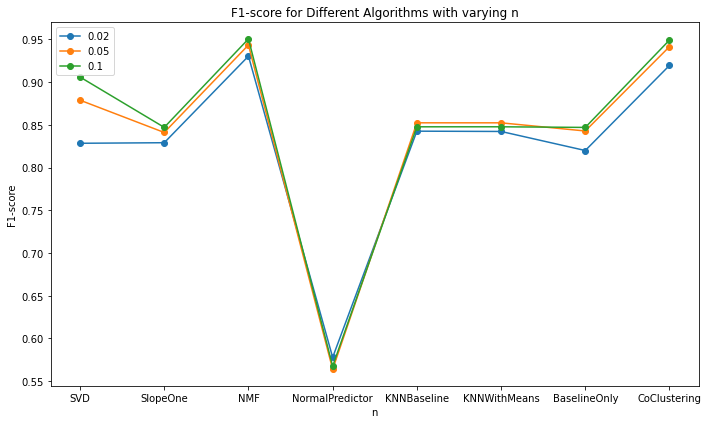

In [19]:
# Create a DataFrame from the results dictionary
df_results = pd.DataFrame(results_dict)

# Plot the results
plt.figure(figsize=(10, 6))  # Adjust the figure size as per your preference
for algorithm in df_results.columns:
    plt.plot(df_results.index, df_results[algorithm], marker='o', label=algorithm)

plt.xlabel('n')
plt.ylabel('F1-score')
plt.title('F1-score for Different Algorithms with varying n')
plt.legend()
plt.tight_layout()  # Adjust the spacing between subplots
plt.show()

In [17]:
## 10% de teste no train
algorithms = [SVD(), SlopeOne(), NMF(), NormalPredictor(), KNNBaseline(), KNNWithMeans(), BaselineOnly(), CoClustering()]
results2 = realistic_train_test(algorithms, df_filtered)
results2

RMSE: 0.3086
MAE:  0.2412
RMSE: 0.3913
MAE:  0.3015
RMSE: 0.2433
MAE:  0.1715
RMSE: 0.6092
MAE:  0.4936
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.3630
MAE:  0.2650
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.3645
MAE:  0.2668
Estimating biases using als...
RMSE: 0.3988
MAE:  0.3485
RMSE: 0.2356
MAE:  0.1209


,accuracy,precision,recall,f1_score,test_rmse,test_mae
SVD,0.889081,0.887521,0.926166,0.906432,0.308602,0.241219
SlopeOne,0.814951,0.813652,0.883300,0.847047,0.391286,0.301454
NMF,0.942344,0.951954,0.948479,0.950213,0.243264,0.171524
NormalPredictor,0.507844,0.579223,0.554158,0.566413,0.609203,0.493559
KNNBaseline,0.815736,0.814197,0.884111,0.847715,0.362986,0.265030
KNNWithMeans,0.815736,0.814119,0.884246,0.847734,0.364532,0.266801
BaselineOnly,0.814873,0.813551,0.883300,0.846992,0.398790,0.348534
CoClustering,0.940775,0.944088,0.954429,0.949230,0.235633,0.120903


In [18]:
# 5% de teste em treino
algorithms = [SVD(), SlopeOne(), NMF(), NormalPredictor(), KNNBaseline(), KNNWithMeans(), BaselineOnly(), CoClustering()]
results3 = realistic_train_test(algorithms, df_filtered, n=0.05)
results3

RMSE: 0.3717
MAE:  0.3228
RMSE: 0.4004
MAE:  0.3073
RMSE: 0.2515
MAE:  0.1747
RMSE: 0.6085
MAE:  0.4896
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.3717
MAE:  0.2710
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.3733
MAE:  0.2726
Estimating biases using als...
RMSE: 0.4158
MAE:  0.3830
RMSE: 0.2571
MAE:  0.1393


,accuracy,precision,recall,f1_score,test_rmse,test_mae
SVD,0.846440,0.841060,0.906586,0.872595,0.371682,0.322796
SlopeOne,0.808161,0.809603,0.875064,0.841062,0.400449,0.307324
NMF,0.936376,0.951286,0.938365,0.944781,0.251468,0.174653
NormalPredictor,0.510926,0.581950,0.556894,0.569146,0.608489,0.489598
KNNBaseline,0.821020,0.817113,0.890825,0.852379,0.371739,0.271013
KNNWithMeans,0.820871,0.816549,0.891466,0.852365,0.373331,0.272635
BaselineOnly,0.806898,0.798372,0.892491,0.842812,0.415815,0.382978
CoClustering,0.931768,0.936154,0.946950,0.941521,0.257082,0.139272


In [19]:
# 1% de teste em treino
algorithms = [SVD(), SlopeOne(), NMF(), NormalPredictor(), KNNBaseline(), KNNWithMeans(), BaselineOnly(), CoClustering()]
results4 = realistic_train_test(algorithms, df_filtered, n = 0.01)
results4

RMSE: 0.4545
MAE:  0.4366
RMSE: 0.4720
MAE:  0.3132
RMSE: 0.3290
MAE:  0.2098
RMSE: 0.6047
MAE:  0.4874
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.4454
MAE:  0.2885
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.4435
MAE:  0.2894
Estimating biases using als...
RMSE: 0.4671
MAE:  0.4558
RMSE: 0.4178
MAE:  0.2396


,accuracy,precision,recall,f1_score,test_rmse,test_mae
SVD,0.724802,0.704278,0.905500,0.792313,0.454487,0.436586
SlopeOne,0.721093,0.728613,0.826873,0.774640,0.472043,0.313151
NMF,0.883943,0.931034,0.863787,0.896151,0.328955,0.209785
NormalPredictor,0.515301,0.584155,0.568845,0.576398,0.604732,0.487414
KNNBaseline,0.758328,0.765252,0.841147,0.801407,0.445429,0.288502
KNNWithMeans,0.755617,0.765563,0.833764,0.798209,0.443470,0.289377
BaselineOnly,0.723518,0.697776,0.922727,0.794638,0.467054,0.455767
CoClustering,0.816891,0.814764,0.885444,0.848635,0.417806,0.239567


In [20]:
# 2% de teste em treino
algorithms = [SVD(), SlopeOne(), NMF(), NormalPredictor(), KNNBaseline(), KNNWithMeans(), BaselineOnly(), CoClustering()]
results5 = realistic_train_test(algorithms, df_filtered, n = 0.02)
results5

RMSE: 0.4252
MAE:  0.3979
RMSE: 0.4139
MAE:  0.2971
RMSE: 0.2795
MAE:  0.1852
RMSE: 0.6156
MAE:  0.4991
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.3877
MAE:  0.2690
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.3888
MAE:  0.2702
Estimating biases using als...
RMSE: 0.4418
MAE:  0.4249
RMSE: 0.3039
MAE:  0.1616


,accuracy,precision,recall,f1_score,test_rmse,test_mae
SVD,0.793342,0.778160,0.900360,0.834812,0.425224,0.397892
SlopeOne,0.797521,0.812105,0.846813,0.829096,0.413936,0.297060
NMF,0.920450,0.951150,0.909554,0.929887,0.279476,0.185201
NormalPredictor,0.500432,0.572093,0.550130,0.560897,0.615578,0.499056
KNNBaseline,0.813662,0.825916,0.859983,0.842605,0.387710,0.268961
KNNWithMeans,0.813374,0.826066,0.859113,0.842266,0.388761,0.270161
BaselineOnly,0.774391,0.763220,0.885824,0.819964,0.441820,0.424934
CoClustering,0.906182,0.915098,0.923966,0.919510,0.303866,0.161610


In [42]:
##n_factors: 100, n_epochs:20, biased:True, lr_all: 0.005, reg_all:0.02
nmf_params = {'n_factors': 100, 'n_epochs': 60, 'biased': True}

algorithms = [NMF(**nmf_params)]
results1, top10_high,top10_low = realistic_train_test(algorithms, df_filtered)
results1

RMSE: 0.3722
MAE:  0.2712


,accuracy,precision,recall,f1_score,test_rmse,test_mae
NMF,0.813853,0.812702,0.882488,0.846159,0.372214,0.271229


In [45]:
print("Top 10 Users with the Highest Errors:")
for user_name, user_partido, error in top10_high:
    print(f"{user_name} ({user_partido}), Error: {error}")

Top 10 Users with the Highest Errors:
Joenia Wapichana (REDE), Error: 30.105589459565106
Denis Bezerra (PSB), Error: 27.12363314714448
Professor Israel Batista (PSB), Error: 27.027394345246492
Vivi Reis (PSOL), Error: 26.931646701894834
Vilson da Fetaemg (PSB), Error: 26.614744664220463
Elias Vaz (PSB), Error: 26.582209465850408
Nilto Tatto (PT), Error: 25.881566056731714
Leo de Brito (PT), Error: 25.576268519909807
Frei Anastacio Ribeiro (PT), Error: 25.29715115972822
Jesus Sérgio (PDT), Error: 25.11935915601362


In [44]:
print("Top 10 Users with the Highest Errors:")
for user_name, user_partido, error in top10_low:
    print(f"{user_name} ({user_partido}), Error: {error}")

Top 10 Users with the Highest Errors:
Sargento Alexandre (PODE), Error: 0.12933827627335193
Lucas Follador (PSC), Error: 0.13749606266296943
Marco Brasil (PP), Error: 0.14907639848553023
Edna Henrique (REPUBLICANOS), Error: 0.17666184067654644
Eliza Virgínia (PP), Error: 0.18776919380547552
Alexandre Figueiredo (PSD), Error: 0.2198772189937377
Dr. Agripino Magalhães (UNIÃO), Error: 0.22731485043053412
Ronaldo Martins (REPUBLICANOS), Error: 0.34366925263938064
Lucas Vergilio (SOLIDARIEDADE), Error: 1.124861561411143
Flávia Arruda (PL), Error: 1.3624512497132282


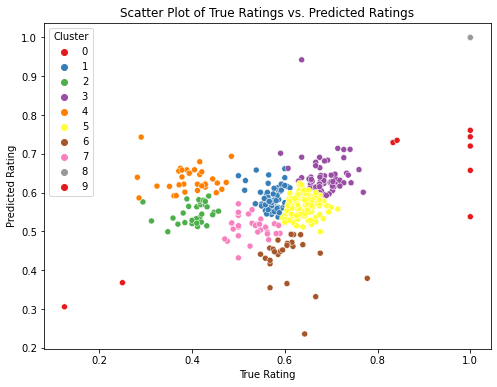

In [31]:
# Scatter Plot
plt.figure(figsize=(8, 6))
sns.scatterplot(data=clusters_users, x='True Rating', y='Predicted Rating', hue='Cluster', palette='Set1')
plt.title('Scatter Plot of True Ratings vs. Predicted Ratings')
plt.xlabel('True Rating')
plt.ylabel('Predicted Rating')
plt.show()

In [43]:
def compare_cluster_statistics(df, cluster_column):
    plt.figure(figsize=(10, 6))
    plt.bar(df[cluster_column], df['True Rating'], alpha=0.7, label='True Rating')
    plt.bar(df[cluster_column], df['Predicted Rating'], alpha=0.7, label='Predicted Rating')
    plt.xlabel('Cluster')
    plt.ylabel('Rating')
    plt.title('Comparison of Ratings by Cluster')
    plt.legend()
    plt.show()


import seaborn as sns

def analyze_voting_patterns(df, cluster_column):
    cluster_stats = df.groupby(cluster_column)['True Rating'].value_counts(normalize=True).unstack().fillna(0)
    cluster_stats = cluster_stats.reset_index().melt(id_vars=cluster_column, var_name='Voting Outcome', value_name='Percentage')
    
    ## Plot Clusters
    plt.figure(figsize=(10, 6))
    sns.barplot(x=cluster_column, y='Percentage', hue='Voting Outcome', data=cluster_stats, palette='Set2')
    plt.show()

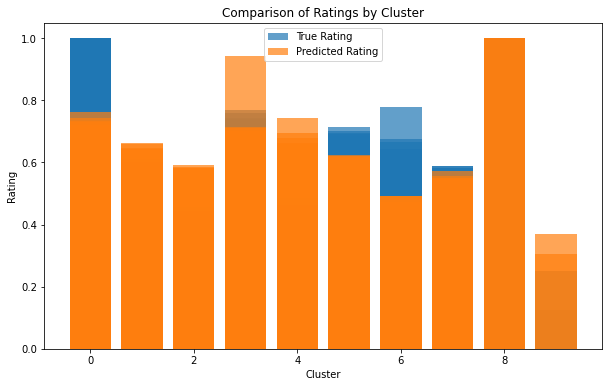

In [39]:
compare_cluster_statistics(clusters_users, 'Cluster')

## Identify similar users

In [22]:
matrix = df_bool.pivot_table(index='deputado_enc', columns='idVotacao', values='vote_enc')
matrix.head()

idVotacao,105464-319,105464-326,1116134-78,1215346-62,1215346-65,15460-156,15460-165,15460-170,15460-173,15460-176,...,534328-200,534328-203,542454-42,542454-51,542454-55,596844-116,601739-113,622070-128,945554-180,945554-186
deputado_enc,,,,,,,,,,,,,,,,,,,,,
0,0.0,NaN,NaN,1.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,NaN,NaN,NaN,1.0,NaN,NaN,0.0,0.0
1,0.0,0.0,NaN,1.0,0.0,0.0,NaN,0.0,1.0,0.0,...,0.0,0.0,NaN,NaN,NaN,1.0,NaN,NaN,NaN,0.0
2,NaN,NaN,NaN,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,NaN,NaN,NaN,NaN,NaN,1.0,0.0,0.0
3,NaN,NaN,NaN,1.0,1.0,1.0,1.0,0.0,NaN,NaN,...,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0
4,NaN,NaN,NaN,1.0,NaN,0.0,1.0,0.0,NaN,0.0,...,NaN,0.0,NaN,NaN,NaN,1.0,NaN,1.0,0.0,0.0


In [23]:
matrix_norm = matrix.subtract(matrix.mean(axis=1), axis = 'rows')
matrix_norm.head()

idVotacao,105464-319,105464-326,1116134-78,1215346-62,1215346-65,15460-156,15460-165,15460-170,15460-173,15460-176,...,534328-200,534328-203,542454-42,542454-51,542454-55,596844-116,601739-113,622070-128,945554-180,945554-186
deputado_enc,,,,,,,,,,,,,,,,,,,,,
0,-0.545732,NaN,NaN,0.454268,-0.545732,-0.545732,0.454268,-0.545732,0.454268,-0.545732,...,-0.545732,-0.545732,NaN,NaN,NaN,0.454268,NaN,NaN,-0.545732,-0.545732
1,-0.558739,-0.558739,NaN,0.441261,-0.558739,-0.558739,NaN,-0.558739,0.441261,-0.558739,...,-0.558739,-0.558739,NaN,NaN,NaN,0.441261,NaN,NaN,NaN,-0.558739
2,NaN,NaN,NaN,0.469751,-0.530249,0.469751,-0.530249,-0.530249,-0.530249,-0.530249,...,-0.530249,-0.530249,NaN,NaN,NaN,NaN,NaN,0.469751,-0.530249,-0.530249
3,NaN,NaN,NaN,0.402135,0.402135,0.402135,0.402135,-0.597865,NaN,NaN,...,-0.597865,-0.597865,NaN,NaN,NaN,NaN,NaN,NaN,-0.597865,-0.597865
4,NaN,NaN,NaN,0.417355,NaN,-0.582645,0.417355,-0.582645,NaN,-0.582645,...,NaN,-0.582645,NaN,NaN,NaN,0.417355,NaN,0.417355,-0.582645,-0.582645


In [24]:
user_similarity = matrix_norm.T.corr()
user_similarity.head()

deputado_enc,0,1,2,3,4,5,6,7,8,9,...,358,359,360,361,362,363,364,365,366,367
deputado_enc,,,,,,,,,,,,,,,,,,,,,
0,1.000000,0.862050,0.856001,0.849941,0.864348,0.279251,0.976962,-0.288484,0.830705,0.849508,...,-0.322967,0.741857,0.242169,0.547762,-0.535611,0.857699,-0.363449,-0.278932,0.751018,-0.589015
1,0.862050,1.000000,0.876407,0.771096,0.799843,0.351741,0.872330,-0.339790,0.862212,0.884840,...,-0.373321,0.835373,0.316404,0.544875,-0.544176,0.868074,-0.428028,-0.338223,0.833813,-0.591548
2,0.856001,0.876407,1.000000,0.844004,0.853446,0.302602,0.885064,-0.372730,0.861893,0.880769,...,-0.407651,0.774034,0.223783,0.586437,-0.534753,0.879424,-0.450733,-0.370446,0.767767,-0.560098
3,0.849941,0.771096,0.844004,1.000000,0.842976,0.231391,0.869981,-0.185485,0.803014,0.796017,...,-0.293267,0.739789,0.203639,0.548159,-0.418592,0.754924,-0.297273,-0.234793,0.769814,-0.472047
4,0.864348,0.799843,0.853446,0.842976,1.000000,0.197871,0.877810,-0.176580,0.792118,0.830261,...,-0.161710,0.822292,0.174750,0.778219,-0.350972,0.852469,-0.259664,-0.080395,0.814670,-0.367360


In [30]:
picked_userid = 358
# Number of similar users
n = 10
# User similarity threashold
user_similarity_threshold = 0.3
# Get top n similar users
similar_users = user_similarity[user_similarity[picked_userid]>user_similarity_threshold][picked_userid].sort_values(ascending=False)[:n]
# Print out top n similar users
print(f'The similar users for user {picked_userid} are', similar_users)

The similar users for user 358 are deputado_enc
358    1.000000
10     0.952119
227    0.947677
138    0.944401
339    0.939360
37     0.938610
41     0.936896
251    0.931104
7      0.928250
53     0.927410
Name: 358, dtype: float64
